In [2]:
# Import des packages nécessaires
!pip install opencv-contrib-python==4.4.0.44
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pickle
import sklearn
from shutil import copyfile
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [ ]:
class_name = {'1001-1059':'pubescent bamboo', '1060-1122':'Chinese horse chestnut', '1552-1616':'Anhui Barberry', '1123-1194':'Chinese redbud', '1195-1267':'true indigo', '1268-1323':'Japanese maple',
             '1324-1385':'Nanmu', '1386-1437':'castor aralia', '1497-1551':'Chinese cinnamon', '1438-1496':'goldenrain tree', '2001-2050':'Big-fruited Holly', '2051-2113':'Japanese cheesewood', '2114-2165':'wintersweet',
             '2166-2230':'camphortree', '2231-2290':'Japan Arrowwood', '2291-2346':'sweet osmanthus', '2347-2423':'deodar', '2424-2485':'ginkgo', '2486-2546':'Crape myrtle', '2547-2612':'oleander', '2616-2675':'yew plum pine', '3001-3055':'Japanese Flowering Cherry',
             '3056-3110':'Glossy Privet', '3111-3175':'Chinese Toon', '3176-3229':'peach', '3230-3281':'Ford Woodlotus', '3282-3334':'trident maple', '3335-3389':'Beales barberry', '3390-3446':'southern magnolia', '3447-3510':'Canadian poplar',
             '3511-3563':'Chinese tulip tree', '3566-3621':'tangerine'}

In [6]:
print(len(class_name))


32


In [3]:
# Définition des chemins d'accès aux datasets
data_dir1 ='./Leaves/'
data_dir2 = './data_2/'
print(len(os.listdir(data_dir1)))

1907


In [ ]:
# Fonction pour récupérer les images et les regrouper dans des sous dossier
for key, item in class_name.items():
    nb1 = int(key.split('-')[0])
    nb2 = int(key.split('-')[1])
    my_path = data_dir2+item
    if not os.path.exists(my_path):
        os.makedirs(my_path)
    for image in os.listdir(data_dir1):
        img_name = image.split('.')[0]
        if nb1 <= int(img_name) <= nb2:
            copyfile(os.path.join(data_dir1, image), os.path.join(my_path, img_name + '.' + image.split('.')[1]))
            

In [5]:
classes = os.listdir(data_dir2)

In [6]:
# Chargement du dataset et séparation trainset et testset
def LoadData(dataDir,new_size=None):
    if not new_size is None:
        img_rows, img_cols = new_size
    classes=[]
    for _,dirs,_ in os.walk(dataDir):
        classes=dirs 
        break  
    num_classes=len(classes)    
    ValidPercent=30  
    X_tr=[]
    Y_tr=[]
    X_te=[]
    Y_te=[]    
    for idx,cl in enumerate(classes):
        for _,_,files in os.walk(dataDir+cl+'/'):               
            l=len(files)
            for f in files:
                r=np.random.randint(100) 
                img_path=dataDir+cl+'/'+f
                img=cv.imread(img_path)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                if not new_size is None:
                    img=cv.resize(img,(img_rows,img_cols))
                if (r>ValidPercent):
                    X_tr.append(img)
                    Y_tr.append(idx)  
                else:
                    X_te.append(img)
                    Y_te.append(idx)                      
    return X_tr, Y_tr, X_te, Y_te

Nombre d'images d'entrainement: 1305 
Nombre de label de train: 1305
Nombre d'images de test: 602
Nombre de label de test: 602


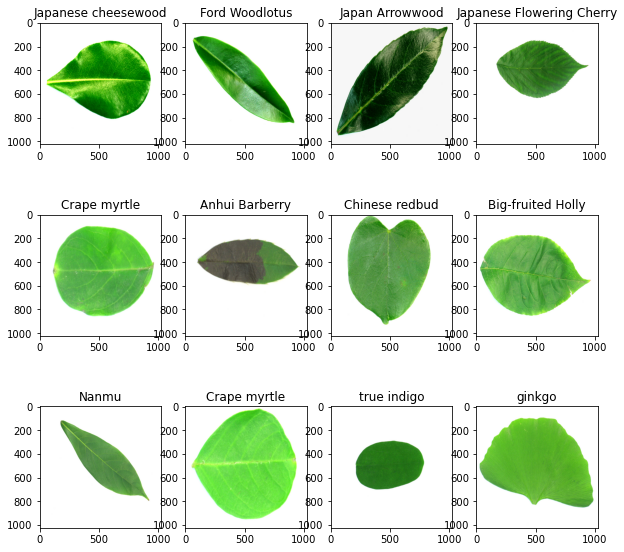

In [7]:
new_size=(1024,1024)
img_train,label_train, img_test, label_test=LoadData(data_dir2, new_size)
print("Nombre d'images d'entrainement: %d " % (len(img_train)))
print("Nombre de label de train: %d" % (len(label_train)))

print("Nombre d'images de test: %d" % (len(img_test)))
print("Nombre de label de test: %d" % (len(label_test)))

# Afficher quelques images avec leurs classes
idxs=np.random.permutation(len(img_train))
plt.figure(figsize = (10,10))
for i in range(12): 
    idx=idxs[i]
    plt.subplot(3,4,i+1)
    plt.imshow(img_train[idx])
    plt.title(classes[label_train[idx]])
plt.show()

In [8]:
# Calcu des descripteurs 
def extract_sift_features(X):
    image_descriptors = []
    sift = cv.SIFT_create()
    for i in range(len(X)):
        kp, des = sift.detectAndCompute(X[i], None)         
        image_descriptors.append(des)
    return image_descriptors

In [9]:
# Extratction des features du jeu de données d'entrainement
image_descriptors = extract_sift_features(img_train)

In [10]:
print(len(image_descriptors))
print(type(image_descriptors[0][0]))
print((image_descriptors[0].shape))
for i in range(10):
    print("L'image {} a {} descripteurs".format(i, len(image_descriptors[i])))

1305
<class 'numpy.ndarray'>
(128, 128)
L'image 0 a 128 descripteurs
L'image 1 a 57 descripteurs
L'image 2 a 34 descripteurs
L'image 3 a 27 descripteurs
L'image 4 a 44 descripteurs
L'image 5 a 39 descripteurs
L'image 6 a 29 descripteurs
L'image 7 a 57 descripteurs
L'image 8 a 50 descripteurs
L'image 9 a 41 descripteurs


In [11]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Nombres total des descripteurs: %d' %(len(all_descriptors)))

Nombres total des descripteurs: 1111021


In [13]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []
    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_
    return bow_dict

In [14]:
num_clusters = 96
if not os.path.isfile('bow_dictionary96.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)    
    pickle.dump(BoW, open('bow_dictionary96.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary96.pkl', 'rb'))
print(len(BoW))
print(len(BoW[0]))

96
128


In [15]:
from scipy.spatial.distance import cdist
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []
    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters) 
        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)            
            argmin = np.argmin(distance, axis=1)            
            for j in argmin:
                features[j] += 1
        X_features.append(features)
    return X_features

In [16]:
image_descriptors = extract_sift_features(img_train)
X_tr = create_features_bow(image_descriptors, BoW, num_clusters)
X_tr=np.array(X_tr)
Y_tr=np.array(label_train)
print('Affichage de la taille de train ')
print("train data: " + str(X_tr.shape))
print("train label: " + str(Y_tr.shape))

Affichage de la taille de train 
train data: (1305, 96)
train label: (1305,)


In [17]:
image_descriptors = extract_sift_features(img_test)
X_te = create_features_bow(image_descriptors, BoW, num_clusters)
X_te=np.array(X_te)
Y_te=np.array(label_test)
print('Affichage de la taille de test')
print("test data: " + str(X_te.shape))
print("test label: " + str(Y_te.shape))

Affichage de la taille de test
test data: (602, 96)
test label: (602,)


In [19]:
svm = sklearn.svm.SVC(kernel="linear")
print(svm)

SVC(kernel='linear')


In [20]:
svm.fit(X_tr, Y_tr)

SVC(kernel='linear')

In [21]:
svm.score(X_tr, Y_tr)

1.0

In [22]:
svm.score(X_te, Y_te)

0.8920265780730897

TypeError: Image data of dtype object cannot be converted to float

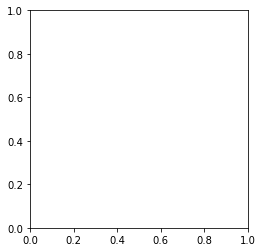

In [23]:
img = None
img = cv.imread('./data_2/castro aralia/1405.jpg')
plt.imshow(img)
plt.show()
my_X = [img]

In [110]:
my_image_descriptors = None
my_X_features = None
my_image_descriptors = extract_sift_features(my_X)
my_X_features = create_features_bow(my_image_descriptors, BoW, num_clusters)
print(len(my_image_descriptors))
print(my_image_descriptors[0].shape)
print(my_X_features[0].shape)
print(my_X_features[0])

1
(610, 128)
(96,)
[  2   0   8   0   0   1   0   1   1   1   0   0   0   0   1   2   0   0
   0   1  43  10   0   1  39   1   1   1   0   2  11   0   0   3   1   2
   2   0   0   0   0   2   0   0   1   1   0   2   0   1   0   3   0 100
   1   0   0   0   2   0   1   0   5   0   0  18   0   0   0   0   0   1
   1   1   2   0   2   0   0   0  20   0   0   7 176   0   0   0   5 106
   0   5   2   8   0   2]


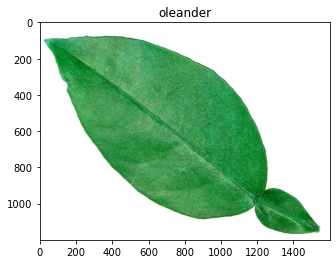

In [115]:
y_pred = None
y_pred = svm.predict(my_X_features)
img = cv.imread('./data_2/tangerine/3615.jpg')
plt.imshow(img)
plt.title(classes[y_pred[0]])
plt.show()